# Optimization method : Exterior Penalty Function (Section 5.7.1 Haftka)

## For the unconstrained search: conjugated gradient + interval reduction method

1) Step size: Golden Search Method, employing the function "minimize_scalar" from scipy.optimize

2) Search direction : Conjugated Gradient, $\mathbf{d}_{(t)} = -\nabla_{\mathbf{x}} f_{(t)} + \beta_{(t)}\mathbf{d}_{(t-1)}$, onde $\beta_{(t)}=\left[\frac{||\nabla_{\mathbf{x}} f_{(t)}||}{||\nabla_{\mathbf{x}} f_{(t-1)}||}\right]^2$ 

The first step consists in defining the algorithms parameters, such as initial point $\mathbf{x}_{(0)}$, $\alpha_{(t)}$ and convergence tolerance constant $\epsilon_{\nabla}$, as well as the function to be minimized and its gradient evaluation:



In [1]:
import numpy as np
from scipy.optimize import minimize_scalar
from plot_descent_penalty import plot_2d_contour, plot_3d_surface
%matplotlib widget

In [2]:
# Problem to be solved and variable for computational cost computation
global problem, r
problem=2
cost_f, cost_g = 0, 0
# Initial guess
x=5*np.array([1, 1])
# Upper bound for the Gold Search algorithm
alpha0=1.0
# Initial value for penalization parameter
r=.1
# Convergence Tolerance
TolG=1e-5
# Maximum number of iterations
itmax=1

Define the objective function to be minimized and its constraints (it must be done by the user):

In [3]:
# Definition of the equation to be minimized
def f_obj(x):
    global problem
    if problem==1:
        f = x[0]**2+10*x[1]**2
        df = np.array([2*x[0], 20*x[1]])
    elif problem==2:
        f=(x[0]-1.5)**2+(x[1]-1.5)**2
        df=np.array([2*(x[0]-1.5), 2*(x[1]-1.5)])
    elif problem==3:
        f=(x[0]-1.5)**2+(x[1]-1.5)**2
        df=np.array([2*(x[0]-1.5), 2*(x[1]-1.5)])
    elif problem==4:
        f=(x[0]-1)**2+(x[1]-1)**2
        df=np.array([2*(x[0]-1), 2*(x[1]-1)])
    elif problem==5:
        L=5 # meters
        f=x[0]*x[1]*L
        df=np.array([(x[1]*L), (x[0]*L)])   
        
    return f, df

# Definition of the constraints: h and g
def nlconstraints(x):
    global problem
    if problem==1:
        h= x[0]+x[1]-4
        dh = np.array([1, 1])
        g=np.array([])
        dg=np.array([])
    elif problem==2:
        h=x[0]+x[1]-2
        dh=np.array([1, 1])
        g=np.array([])
        dg=np.array([])
    elif problem==3:
        h=np.array([])
        dh=np.array(np.zeros(x.shape))
        g=np.array([x[0]+x[1]-2])
        dg=np.array([1, 1])
    elif problem==4:
        h=np.array([])
        dh=np.array(np.zeros(x.shape))
        g=np.array([x[0]+x[1]-4, 2-x[0]])
        dg=np.array([[1, 1],[-1,0]])
    elif problem==5:
        L,Sadm,q = 5, 20e6, 20e3
        h=np.array([])
        dh=np.array(np.zeros(x.shape))
        g=np.array([])
        dg=np.array(np.zeros(x.shape))    
    return h, dh, g, dg

From here on, the method is user independent:

In [4]:
# Definition of the penalized function phi
def phi(x):
    global r
    f,df=f_obj(x)
    h,dh,g,dg=nlconstraints(x)

    auxg=np.maximum(0,g)
    ph=f+r*(h.sum()**2 + auxg.sum()**2)
    
    # Construction of the gradient of phi: contribution of the inequality constraints (g_i)
    dgaux=np.array(np.zeros(x.shape))
    if g.size==1:  # splip into two situations: with only one constraints, and more constraints
        dgaux=dg*np.maximum(0,g)
    else:
        for i in range(g.size):
            dgaux=dgaux+dg[i,:]*np.maximum(0,g[i])
        
    # Construction of the gradient of phi: contribution of the equality constraints (h_j)
    dhaux=np.array(np.zeros(x.shape))
    if h.size==1:  # slip into two situations: with only one constraints, and more constraints
        dhaux=dh*h
    else:
        for j in range(h.size):
            dhaux=dhaux+dh[j,:]*h[j]
        
        
    dph=df+2*r*(dhaux + dgaux)
    return ph, dph

# Definition of the equation to be minimized as function of the step size alpha
def f_alpha(alpha,args):
    xk,d=args[0],args[1]
    xaux=xk+alpha*d
    f,df=phi(xaux)
    return f

Definition of the unconstrained optimization algorithm:


In [5]:
def CG_GS(x,alpha0,TolG):
    # Count variable
    t=0
    # f and df values at the initial point
    [f,df]=phi(x)
    dftm1=df
    
    xs = [x]
    fs = [f]
        
    while np.sqrt(df @ df)>TolG:
        # Search direction: Conjugated Gradient
        beta = (np.linalg.norm(df)/np.linalg.norm(dftm1))**2
 
        if t==0:
            d=-df
        else:
            d=-df+beta*dtm1
            
        # Step determination: Golden Search (method='golden'), Brent (method='brent') or Bounded (method='bounded')
        alpha=minimize_scalar(f_alpha, bounds=(.001, alpha0), args=([x,d]), method='bounded')

        # Update the current point 
        xt=x+alpha.x*d
        xs.append(xt)
        
        # Saves information of gradient and descent direction of current iteration
        dftm1=df
        dtm1=d
    
        # Evaluate the objective function and gradient at the new point
        [f,df]=phi(xt)
        fs.append(f)
    
        # Update the design variable and iteration number 
        x=xt
        t=t+1
    return x,f,df,t,xs,fs

External Penalty method iterative scheme:

In [6]:
k=0
points = []
values = []
while k<itmax: # implement here additional stopping criteria
    xt,f,df,t,xs,fs=CG_GS(x,alpha0,TolG)
    points.append(xs)
    values.append(fs)
    r=r*5
    x=xt
    k=k+1
    cost_f += t
    cost_g += t
    
fopt,dfopt=f_obj(xt)
hopt,dhopt,gopt,dgopt=nlconstraints(xt)

The optimum design is stored in the variable $x$. Once the results are obtained, we may print them:

In [7]:
fopt,dfopt=f_obj(x)
hopt,dhopt,gopt,dgopt=nlconstraints(x)
print('Optimum found:')
print(xt)
print('Objective function value at the optimum:')
print(fopt)
print('Inequality constraints at the optimum:')
print(gopt)
print('Equality constraints at the optimum:')
print(hopt)

print('Number of times that the f_obj function and constraints were evaluated, respectively:')
print(cost_f)
print(cost_g)
print('Number of iterations of the External penalty method:')
print(k)


Optimum found:
[1.41666667 1.41666667]
Objective function value at the optimum:
0.013888888888888938
Inequality constraints at the optimum:
[]
Equality constraints at the optimum:
0.833333333333333
Number of times that the f_obj function and constraints were evaluated, respectively:
1
1
Number of iterations of the External penalty method:
1


[[[5.         5.        ]
  [1.41666667 1.41666667]]]


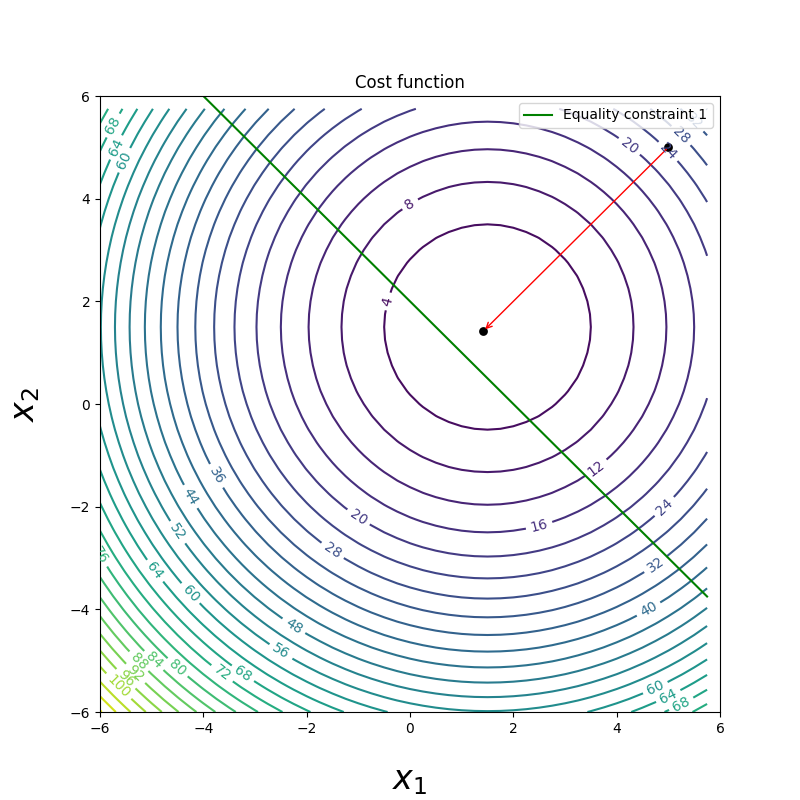

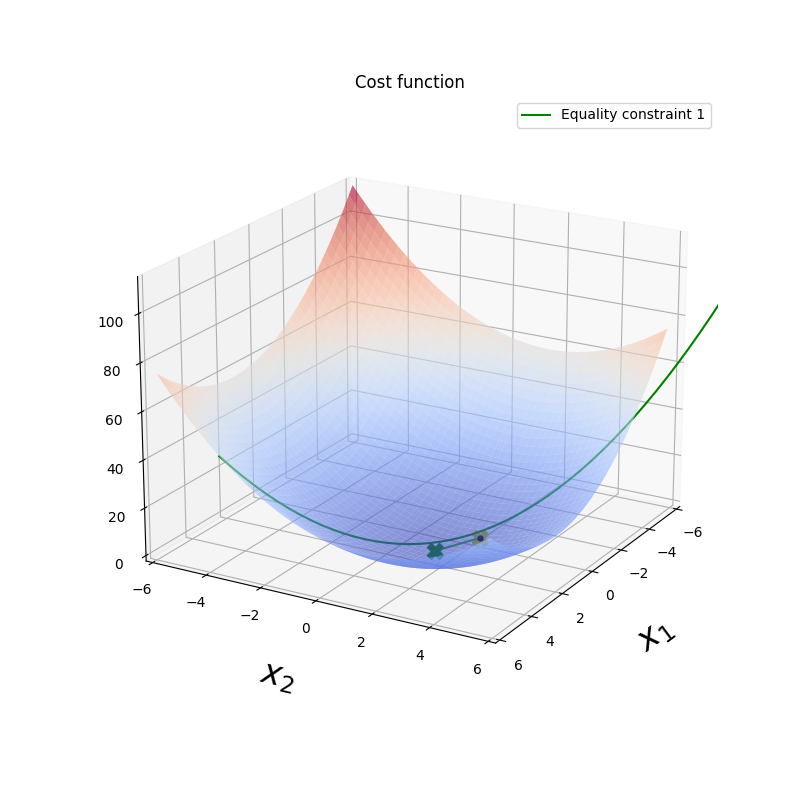

In [8]:
N = 10 # number of points to plot

plot_2d_contour(points[:N], f_obj, plot_h=True, plot_g=True, f_constraints=nlconstraints)
plot_3d_surface(points[:N], values[:N], f_obj, plot_h=True, plot_g=True, f_constraints=nlconstraints)